# **Задача 1.**
Давайте решим задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:

- age
- workclass
- fnlwgt
- education
- education-num
- marital-status
- occupation
- relationship
- race
- sex
- capital-gain
- capital-loss
- hours-per-week

Оценивать качество мы будем с помощью ROC-AUC.

# **Подбор гиперпараметров модели**
В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют перебор по сетке (grid search): для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку.

Есть несколько схем, как это можно реализовать:

- Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит переобучение на тестовую выборку.
- Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (train), валидация (validation) и контроль (test). Валидационную подвыборку используют для сравнения моделей, а test — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
- Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
- Leave-One-Out
- K-Fold
- Многократное случайное разбиение выборки

Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:

- сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
- кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
- параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации, такая стратегия не всегда приводит к оптимальному набору;
- перебирать не все комбинации параметров, а небольшое число случайно выбранных.

# 1. Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns

# 2. Загружаем наш датасет

In [2]:
adult_df = pd.read_csv('data.adult.csv')
adult_df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
10256,24,Private,24243,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,1590,40,<=50K
8130,41,Private,307468,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,<=50K
12170,45,Private,293691,HS-grad,9,Divorced,Adm-clerical,Not-in-family,Asian-Pac-Islander,Female,0,1590,40,<=50K
11803,29,Private,271579,10th,6,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,<=50K
5151,23,?,194031,Some-college,10,Never-married,?,Not-in-family,White,Female,0,0,25,<=50K
16114,33,Private,236396,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,35,<=50K
15013,46,Private,133169,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,<=50K
11643,25,Private,112835,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,<=50K
14048,26,Private,96467,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,<=50K
7795,46,Local-gov,222115,Bachelors,13,Divorced,Adm-clerical,Not-in-family,White,Female,99999,0,40,>50K


# 3. Оценка данных

In [3]:
# выведем размерность нашего датасета:
adult_df.shape

(16280, 14)

In [4]:
# выведем типы данных:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [5]:
adult_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

In [6]:
# выведем основные статистические показатели:
adult_df.describe().round(3)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16280.000,16280.000,16280.000,16280.000,16280.000,16280.000
mean,38.635,189459.422,10.098,1020.418,86.696,40.404
std,13.635,106664.404,2.568,6862.042,402.309,12.341
min,17.000,19302.000,1.000,0.000,0.000,1.000
25%,28.000,117006.750,9.000,0.000,0.000,40.000
50%,37.000,178134.000,10.000,0.000,0.000,40.000
75%,48.000,237163.000,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


# 4. Feature Engineering:

##4.1. Удалим Nan

In [7]:
# В данном датасете пропущенные значения обозначены как "?".
# workclass & occupation содержат пропущенные значения.
adult_df.isin(['?']).any()

age               False
workclass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

In [8]:
# Найдем все признаки, имеющие пропущенные значения. Удалим из выборки все объекты с пропусками.
adult_df = adult_df[(adult_df.workclass != '?') & (adult_df.occupation != '?')].copy()
adult_df.isin(['?']).any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
>50K,<=50K        False
dtype: bool

##Преобразовываем в бинарный формат:



In [9]:
adult_df['>50K,<=50K'] = adult_df['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else -1)
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,-1
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,-1
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,-1
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,-1
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,1


#5. делим на train и test

In [10]:
# Выделим целевую переменную в y, числовые признаки - в Х

y = adult_df['>50K,<=50K']
X = adult_df[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


In [11]:
# Разобьем Х на тест и трейн
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)


#6. **Обучение классификаторов на вещественных признаках**
В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:

- kNN
- SGD Linear Classifier (SVС со стохастическим градиентным спуском)
- Naive Bayes Classifier
- Logistic Regression
- SVC (Support Vector Classifier)

Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:

- kNN — число соседей (n_neighbors)
- SGD Linear Classifier — оптимизируемая функция (loss)

Остальные параметры будем оставлять в значениях по умолчанию. Для подбора гиперпараметров воспользуемся перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации будем использовать 5-fold cv.

Для каждого из первых двух алгоритмов подберем оптимальные значения указанных гиперпараметров. Построим график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразим доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [12]:
def plotting(grid, params):
    """Функция для построения графиков"""
    scores_mean = grid.cv_results_['mean_test_score']
    scores_sd = grid.cv_results_['std_test_score']

    fig, ax = plt.subplots()
    ax.plot(params,scores_mean)
    ax.fill_between(params, (scores_mean-scores_sd), (scores_mean+scores_sd), color='g', alpha=.1)

In [13]:
def model_train(model, param_grid, hyperparams):
    """Функция подбора гиперпараметров, вызывает функцию с графиками"""
    grid = GridSearchCV(model, param_grid, scoring='roc_auc')  # если не передавать cv явно, как раз будет использована 5-fold cv
    grid.fit(Xtrain, ytrain)
    plotting(grid, hyperparams)
    print(f'Best params: {grid.best_params_}')
    best = grid.best_estimator_
    y_pred_train = best.predict(Xtrain)
    y_pred_test = best.predict(Xtest)
    print(classification_report(ytrain, y_pred_train), classification_report(ytest, y_pred_test))
    print(roc_auc_score(ytrain, y_pred_train), roc_auc_score(ytest, y_pred_test))


##**6.1 KNN Classifier**

In [14]:
model = KNeighborsClassifier()
hyperparams = list(range(2, 30)) # k=2 до k=30
param_grid = {'n_neighbors': hyperparams}

KNN results
Best params: {'n_neighbors': 5}
              precision    recall  f1-score   support

          -1       0.83      0.95      0.89      8550
           1       0.76      0.42      0.54      2960

    accuracy                           0.82     11510
   macro avg       0.79      0.69      0.71     11510
weighted avg       0.81      0.82      0.80     11510
               precision    recall  f1-score   support

          -1       0.79      0.92      0.85      2857
           1       0.55      0.30      0.39       980

    accuracy                           0.76      3837
   macro avg       0.67      0.61      0.62      3837
weighted avg       0.73      0.76      0.73      3837

0.6875813971866603 0.6091784946390176


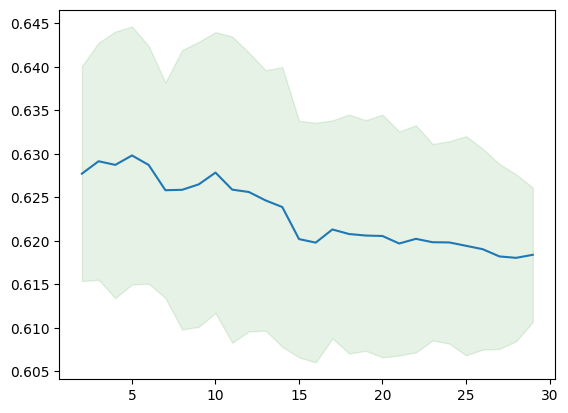

In [15]:
print('KNN results')
model_train(model, param_grid, hyperparams)

In [16]:
# Попробуем нормализовать

model = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
# make_pipeline(...)
'kneighborsclassifier__n_neighbors'
hyperparams = list(range(2, 30))
param_grid = {'knn__n_neighbors': hyperparams}

Normalised KNN results
Best params: {'knn__n_neighbors': 29}
              precision    recall  f1-score   support

          -1       0.84      0.94      0.89      8550
           1       0.74      0.48      0.58      2960

    accuracy                           0.82     11510
   macro avg       0.79      0.71      0.73     11510
weighted avg       0.81      0.82      0.81     11510
               precision    recall  f1-score   support

          -1       0.83      0.94      0.88      2857
           1       0.70      0.43      0.53       980

    accuracy                           0.81      3837
   macro avg       0.76      0.68      0.71      3837
weighted avg       0.80      0.81      0.79      3837

0.7103846609767662 0.6841397427014207


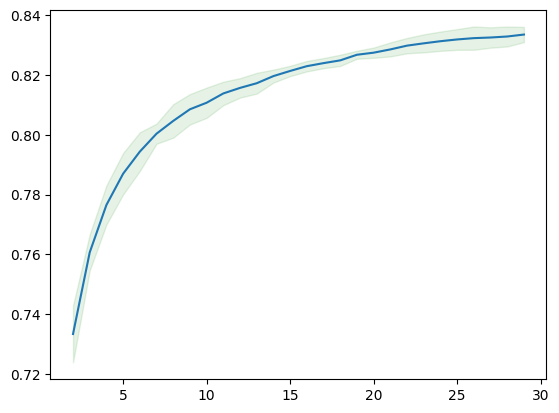

In [17]:
print('Normalised KNN results')
model_train(model, param_grid, hyperparams)

##**6.2 SGDClassifier** - стохаотический градиентный спуск



In [18]:
model = SGDClassifier()
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'loss': hyperparams}

SGD results
Best params: {'loss': 'modified_huber'}
              precision    recall  f1-score   support

          -1       0.77      0.99      0.86      8550
           1       0.80      0.12      0.21      2960

    accuracy                           0.77     11510
   macro avg       0.78      0.56      0.54     11510
weighted avg       0.77      0.77      0.70     11510
               precision    recall  f1-score   support

          -1       0.77      0.99      0.87      2857
           1       0.87      0.14      0.24       980

    accuracy                           0.77      3837
   macro avg       0.82      0.57      0.55      3837
weighted avg       0.80      0.77      0.71      3837

0.5559374506085033 0.5658875800932903


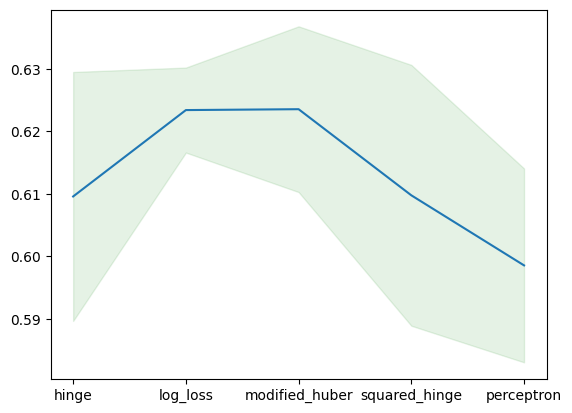

In [19]:
print('SGD results')
model_train(model, param_grid, hyperparams)

In [20]:
# Попробуем нормализовать

model = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier())
])
hyperparams = ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']
param_grid = {'sgd__loss': hyperparams}

Normalised SGD results
Best params: {'sgd__loss': 'log_loss'}
              precision    recall  f1-score   support

          -1       0.82      0.93      0.87      8550
           1       0.67      0.42      0.52      2960

    accuracy                           0.80     11510
   macro avg       0.75      0.68      0.70     11510
weighted avg       0.78      0.80      0.78     11510
               precision    recall  f1-score   support

          -1       0.82      0.93      0.87      2857
           1       0.67      0.41      0.51       980

    accuracy                           0.80      3837
   macro avg       0.75      0.67      0.69      3837
weighted avg       0.78      0.80      0.78      3837

0.6757554923344398 0.670129935068182


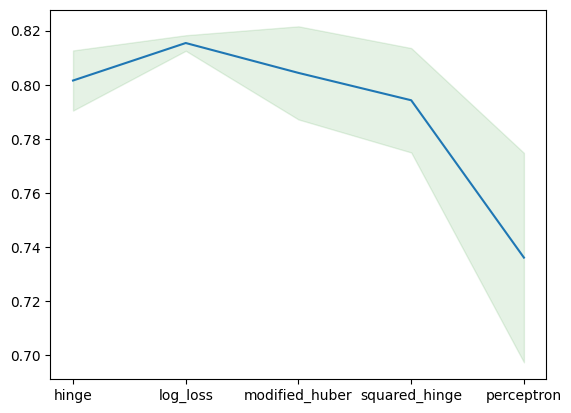

In [21]:
print('Normalised SGD results')
model_train(model, param_grid, hyperparams)

hinge - это SVM, log - логистическая регрессия, modified_huber - сглаженный SVM, squared_hinge - SVM, который штрафуется квадратично, perceptron - алгоритм перцептрона (Розенблатт).

Гиперпараметры для остальных алгоритмов попробуйте подобрать сами. Нам осталось посмотреть:

- LogisticRegression
- SVC
- Naive Bayes

Также можете попробовать поработать с категориальными признаками.

##**6.3 LogisticRegression**


In [22]:
model = LogisticRegression()
hyperparams = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
param_grid = {'solver': hyperparams}

LogisticRegression results


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearch

Best params: {'solver': 'newton-cholesky'}
              precision    recall  f1-score   support

          -1       0.82      0.94      0.88      8550
           1       0.71      0.41      0.52      2960

    accuracy                           0.81     11510
   macro avg       0.77      0.68      0.70     11510
weighted avg       0.79      0.81      0.79     11510
               precision    recall  f1-score   support

          -1       0.82      0.94      0.88      2857
           1       0.71      0.40      0.51       980

    accuracy                           0.81      3837
   macro avg       0.77      0.67      0.70      3837
weighted avg       0.79      0.81      0.79      3837

0.6763865180970444 0.673354203424457


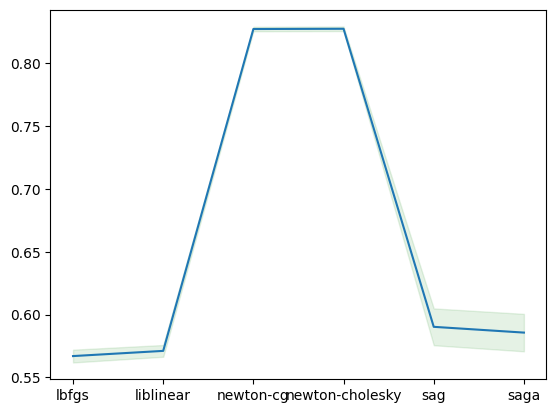

In [23]:
print('LogisticRegression results')
model_train(model, param_grid, hyperparams)

In [24]:
from sklearn.pipeline import make_pipeline

model = Pipeline([
    ('scale', StandardScaler()),
    ('logistic', LogisticRegression())
])

hyperparams = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
param_grid = {'logistic__solver': hyperparams}

Normalised LogisticRegression results
Best params: {'logistic__solver': 'sag'}
              precision    recall  f1-score   support

          -1       0.82      0.94      0.88      8550
           1       0.71      0.41      0.52      2960

    accuracy                           0.81     11510
   macro avg       0.77      0.68      0.70     11510
weighted avg       0.79      0.81      0.79     11510
               precision    recall  f1-score   support

          -1       0.82      0.94      0.88      2857
           1       0.71      0.40      0.51       980

    accuracy                           0.81      3837
   macro avg       0.77      0.67      0.70      3837
weighted avg       0.79      0.81      0.79      3837

0.6765034771613718 0.6735292121748945


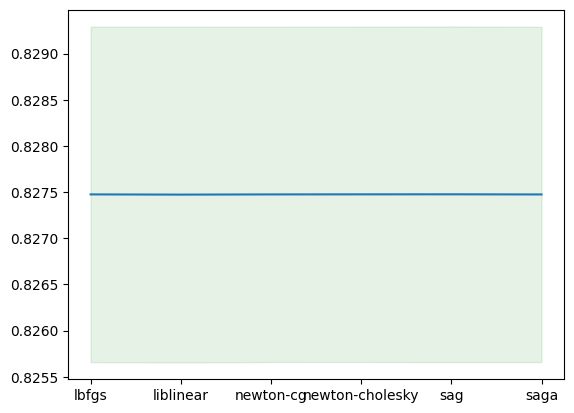

In [25]:
print('Normalised LogisticRegression results')
model_train(model, param_grid, hyperparams)

##**6.4 SVC**

In [26]:
model = SVC()
hyperparams = ['linear', 'poly']
param_grid = {'kernel': hyperparams}

SVC results
Best params: {'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.80      0.95      0.86      8550
           1       0.66      0.30      0.41      2960

    accuracy                           0.78     11510
   macro avg       0.73      0.62      0.64     11510
weighted avg       0.76      0.78      0.75     11510
               precision    recall  f1-score   support

          -1       0.80      0.95      0.87      2857
           1       0.68      0.30      0.42       980

    accuracy                           0.78      3837
   macro avg       0.74      0.63      0.64      3837
weighted avg       0.77      0.78      0.75      3837

0.6223652599968389 0.6270145650139649


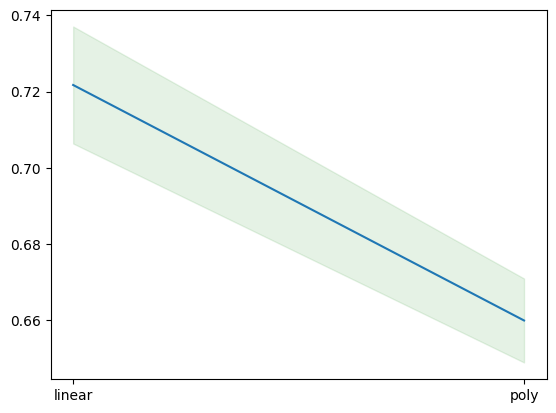

In [ ]:
print('SVC results')
model_train(model, param_grid, hyperparams)

In [ ]:
from sklearn.pipeline import make_pipeline

model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC())
])

hyperparams = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
param_grid = {'kernel': hyperparams}

In [ ]:
print('Normalised SVC results')
model_train(model, param_grid, hyperparams)

Normalised SVC results


ValueError: ignored

#**7. Смешивание моделей**
Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберем из построенных моделей двух предыдущих пунктов две (обозначим их $clf_1$ и $clf_2$). Далее построим новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

In [ ]:
model1 = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=29))
])
model2 = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss'))
])
model1.fit(Xtrain, ytrain)
model2.fit(Xtrain, ytrain)
clf1 = model1.predict_proba(Xtest)
clf2 = model2.predict_proba(Xtest)

In [ ]:
scores = []
for alpha in np.arange(0.1, 1.1, 0.1):
    res = alpha * clf1 + (1 - alpha) * clf2

    pred = []
    for elem in res:
        pred.append(np.argmax(elem))
    scores.append(roc_auc_score(pred, ytest))

    print('alpha:', round(alpha, 1), 'score:', scores[-1])